In [2]:
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 889.9 kB/s eta 0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 10.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 31.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 32.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.7 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.5 MB/s eta 0:00:00m eta 0

Model: Linear Model
Model: Neural Net


/tmp/ipykernel_91203/3604799983.py:78: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  coverage, _ = conformal_prediction(probs, y_test, n_cal=n_cal)


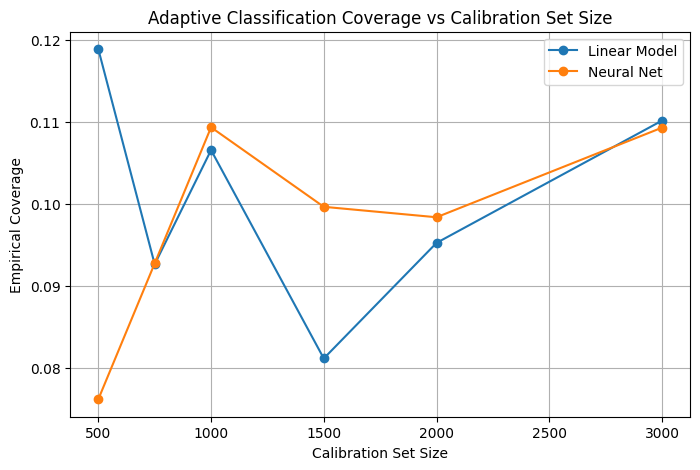

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

def load_fashion_mnist(sample_size=5000):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    idx = np.random.choice(x_train.shape[0], sample_size, replace=False)
    x_train, y_train = x_train[idx], y_train[idx]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_fashion_mnist()

x_train_flat, x_test_flat = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

class LinearClassifier:
    def __init__(self, input_dim, num_classes=10):
        self.weights = np.random.randn(input_dim, num_classes) * 0.01
        self.bias = np.random.randn(num_classes) * 0.01

    def predict_proba(self, X):
        logits = X @ self.weights + self.bias
        return np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

linear_model = LinearClassifier(input_dim=x_train_flat.shape[1])
linear_probs = linear_model.predict_proba(x_test_flat)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=1)

train_tensor = torch.tensor(x_train_flat, dtype=torch.float32)
test_tensor = torch.tensor(x_test_flat, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)

dnn = SimpleNN()
optimizer = optim.Adam(dnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    optimizer.zero_grad()
    loss = loss_fn(dnn(train_tensor), train_labels)
    loss.backward()
    optimizer.step()

dnn_probs = dnn(test_tensor).detach().numpy()

def conformal_prediction(scores, labels, alpha=0.1, n_cal=1000):
    idx = np.random.choice(scores.shape[0], n_cal, replace=False)
    cal_scores, val_scores = scores[idx], np.delete(scores, idx, axis=0)
    cal_labels, val_labels = labels[idx], np.delete(labels, idx, axis=0)
    
    cal_scores_sorted = np.sort(cal_scores[np.arange(n_cal), cal_labels])
    qhat = np.quantile(cal_scores_sorted, np.ceil((n_cal + 1) * (1 - alpha)) / n_cal, interpolation='higher')
    
    prediction_sets = (val_scores >= qhat).astype(int)
    empirical_coverage = prediction_sets[np.arange(len(val_labels)), val_labels].mean()
    return empirical_coverage, prediction_sets

coverages = {}
n_cal_values = [500, 750, 1000, 1500, 2000, 3000]

for model_name, probs in zip(["Linear Model", "Neural Net"], [linear_probs, dnn_probs]):
    print(f"Model: {model_name}")
    coverages[model_name] = []
    for n_cal in n_cal_values:
        coverage, _ = conformal_prediction(probs, y_test, n_cal=n_cal)
        coverages[model_name].append(coverage)

plt.figure(figsize=(8, 5))
for model_name, cov_values in coverages.items():
    plt.plot(n_cal_values, cov_values, marker='o', label=model_name)
plt.xlabel("Calibration Set Size")
plt.ylabel("Empirical Coverage")
plt.title("Adaptive Classification Coverage vs Calibration Set Size")
plt.legend()
plt.grid()
plt.show()